After improvements

- feature scalling
- dropouts
- for binary classifier the numerical stability is imp so  sigmoid with bce works but less numerically stable especially when predicted probabilities are close to 0 and 1 can cause gradient issues 
- used BCEWithLogitsLoss for numerical stability 

Why this is better:
BCEWithLogitsLoss does: sigmoid + log loss in one step

It's more stable for small/large values (avoids log(0) issues)

Slightly faster and preferred in practice for binary classification

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Desktop\github_projects\ML\datasets\Social_Network_Ads.csv")

In [3]:
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


<Axes: xlabel='Age', ylabel='EstimatedSalary'>

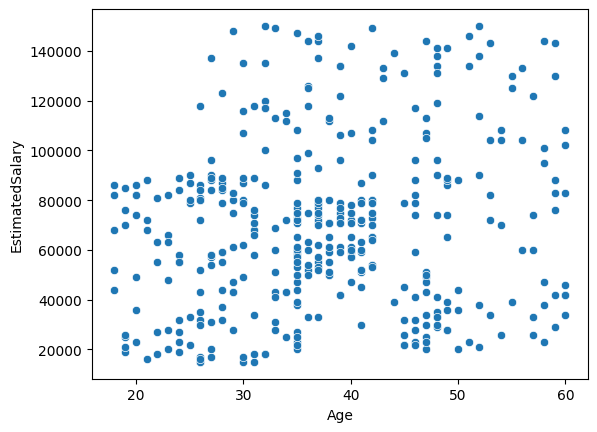

In [4]:
import seaborn as sns

sns.scatterplot(x= df.iloc[:,0], y = df.iloc[:,1])

In [5]:
df.shape

(400, 3)

In [6]:
x = df.iloc[:,0:2]
y = df.iloc[:,-1]

In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [8]:
print(x_train.shape)
print(type(x_train))

(320, 2)
<class 'pandas.core.frame.DataFrame'>


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [12]:

import torch
import torch.nn as nn
from torch.optim import optimizer
from torch.utils.data import TensorDataset,DataLoader 

x_train_tensor = torch.tensor(x_train_scaled, dtype= torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

In [13]:
import torch.nn as nn

class NN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,1)
        )
    
    def forward(self, x):
        return self.nn(x)
        

In [15]:
model = NN(num_features=2)

In [16]:
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)



In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [19]:
for epoch in range(10):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0 
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
        
    
    acc = correct / total
    print(f'[Train] Epoch {epoch + 1}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}')

[Train] Epoch 1, Loss: 6.3399, Accuracy: 0.7156
[Train] Epoch 2, Loss: 5.7202, Accuracy: 0.8094
[Train] Epoch 3, Loss: 5.3372, Accuracy: 0.8125
[Train] Epoch 4, Loss: 4.9382, Accuracy: 0.8375
[Train] Epoch 5, Loss: 4.6601, Accuracy: 0.8438
[Train] Epoch 6, Loss: 4.5431, Accuracy: 0.8500
[Train] Epoch 7, Loss: 4.2759, Accuracy: 0.8406
[Train] Epoch 8, Loss: 4.0236, Accuracy: 0.8531
[Train] Epoch 9, Loss: 3.9970, Accuracy: 0.8594
[Train] Epoch 10, Loss: 3.7869, Accuracy: 0.8594


In [25]:
from sklearn.metrics import accuracy_score , roc_auc_score 

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        probs = torch.sigmoid(outputs)  # logits to probabilities
        all_preds.extend(probs.squeeze().numpy())
        all_labels.extend(batch_y.squeeze().numpy())
        

import numpy as np

predicted_classes = np.array(all_preds)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# class metrics
predicted_classes = (all_preds > 0.5).astype(int)
accuracy = accuracy_score(all_labels, predicted_classes)
roc_auc = roc_auc_score(all_labels, all_preds)

print(f"[Test] Accuracy:{accuracy:.4f}, ROC AUC: {roc_auc:.4f}")



        

[Test] Accuracy:0.8875, ROC AUC: 0.9382


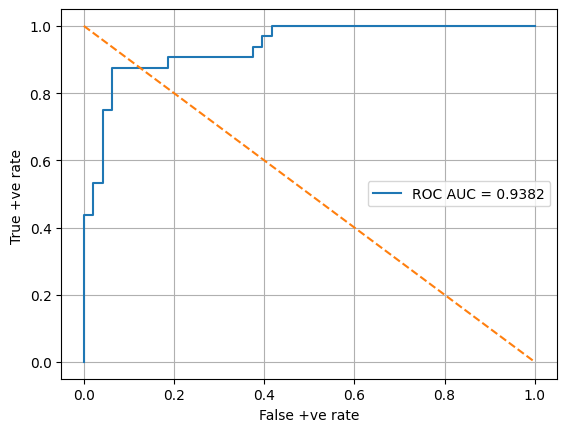

In [28]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr , _ = roc_curve(all_labels, all_preds)
plt.plot(fpr, tpr, label = f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [1,0], linestyle ='--')
plt.xlabel("False +ve rate")
plt.ylabel("True +ve rate ")
plt.legend()
plt.grid()
plt.show()